In [1]:
#Needed in general


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')


# import script that has formation channel classification functions:
from PostProcessingScripts import * 


from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import astropy
import seaborn as sns
from seaborn_utility import cmap_from_colour

changed 3


# FINAL PROPERTIES 

In [2]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    
    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]] 
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
                
        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

        if xvar in ['MassRatioZAMS', 'separationZAMS',  'TotalMassZAMS' , 'M1ZAMS', 'M2ZAMS', 'separationZAMS'  ]:
            M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
            M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
            separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
            Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
            MassRatioZAMS = M2ZAMS / M1ZAMS             
            var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                         'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}   
              
        elif xvar in ['Chirp_mass', 'MBH_from_ZAMSM1', 'MBH_from_ZAMSM2',  'M1LVK', 'M2LVK', 'qLVK', 'Total_mass', \
                     'Effective_spin']:
            
            
            
            M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
            M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()

            
            
            if xvar =='Chirp_mass':
                M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=M1BH, m2=M2BH) 
                var_dict = [chirpmass(M1LVK, M2LVK)]
            elif xvar =='MBH_from_ZAMSM1':
                var_dict =  [M1BH]
            elif xvar =='MBH_from_ZAMSM2':
                var_dict =  [M2BH]
            elif xvar =='M1LVK':
                # M1 will be the most massive, M2 the least massive compact object. 
                M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=M1BH, m2=M2BH) 
                var_dict =  [M1LVK]
                del M1LVK
                del M2LVK
            elif xvar =='M2LVK':
                # M1 will be the most massive, M2 the least massive compact object. 
                M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=M1BH, m2=M2BH) 
                var_dict =  [M2LVK]
                del M1LVK
                del M2LVK
            elif xvar =='qLVK':
                # M1 will be the most massive, M2 the least massive compact object. 
                M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=M1BH, m2=M2BH) 
                var_dict =  [M2LVK/M1LVK]
                del M1LVK
                del M2LVK
            elif xvar =='Total_mass':
                var_dict =  [M1BH + M2BH]
            elif xvar =='Effective_spin':
                # M1 will be the most massive, M2 the least massive compact object. 
#                 M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=M1BH, m2=M2BH) 
                spin = COspin(data_path=path, state='he_depletion')  # set class 
                spin.setCOMPASData() # reads in the COMPAS DCO parameters 
                spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
                chi_effective = (spinMZAMS1*M1BH) + (spinMZAMS2*M2BH)
                chi_effective = chi_effective/(M1BH+M2BH)
                var_dict =  [chi_effective]
                
                del chi_effective
                del spin 
                del spinMZAMS1
                del spinMZAMS2                
                
            del M1BH
            del M2BH
            
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            # make CDF of all BBH systems
            axe.hist(var_dict[0], bins=int(len(var_dict[0])/10), weights=w, cumulative=True, density=True, color='k', histtype='step', lw=4, zorder=6, alpha=1, ls='-')
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[0][mask_MRR], bins=int(len(var_dict[0][mask_MRR])/10), weights=w[mask_MRR], cumulative=True, density=True, color=c_MRR, histtype='step', lw=5, zorder=10, alpha=1, ls='--')
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[0][~mask_MRR], bins=len(var_dict[0][~mask_MRR]), weights=w[~mask_MRR], cumulative=True, density=True, color=c_BBH, histtype='step', lw=3, zorder=10, alpha=1, ls='--')

 
    del fdata
    del var_dict

    # BEAUTIFY:     
    ylabel='CDF'
    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
                  
    if xvar=='MassRatioZAMS':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color='k', zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=3, lw=4.5, alpha=1, ls=':', label = r'$\textbf{MRR} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=3, lw=4.5, alpha=1, ls=':', label = r'$\textbf{not} \  \textbf{MRR} \ \textbf{BBHs}$')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(0.25, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(0,1, 100)
        yy_q = np.linspace(0,1, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)
        
    elif xvar=='separationZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        yy_q = np.linspace(0,1, 100)
        xx_q = np.logspace(-2,3, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)
    
    elif xvar=='M1ZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(5,150, 100)
        yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
        yy_q = np.cumsum(yy_q)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)
     
    elif xvar=='M1LVK':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color='k', zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{MRR} $')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{not} \  \textbf{MRR} $')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(3, 0.6,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      

    
    axe.grid(True)
    _ = layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 

        
    
    if xvar=='separationZAMS' :
        ax.set_xscale('log')
    elif xvar=='Effective_spin':
#         ax.set_yscale('log') 
        ax.set_ylim(0.5, 1)
        ax.set_xlim(0., .5)
        print()
    

    

    return



# PLOT CDF 6 panel 

now running model  M  for x =  Effective_spin
17758634 8879317 8879317
indices =  8879317 [      0       1       2 ... 8879314 8879315 8879316]
self.seedsSN[1::2] [5305000376 5305001759 5305002300 5305002362 5305002468 5305002498
 5305002517 5305002687 5305002875 5305003146]
whichSN1 8879317 [1 1 1 ... 1 1 1]
8879317 8879317 8879317
0  still had negative spin; we set these to 0 

almost done... saving figure


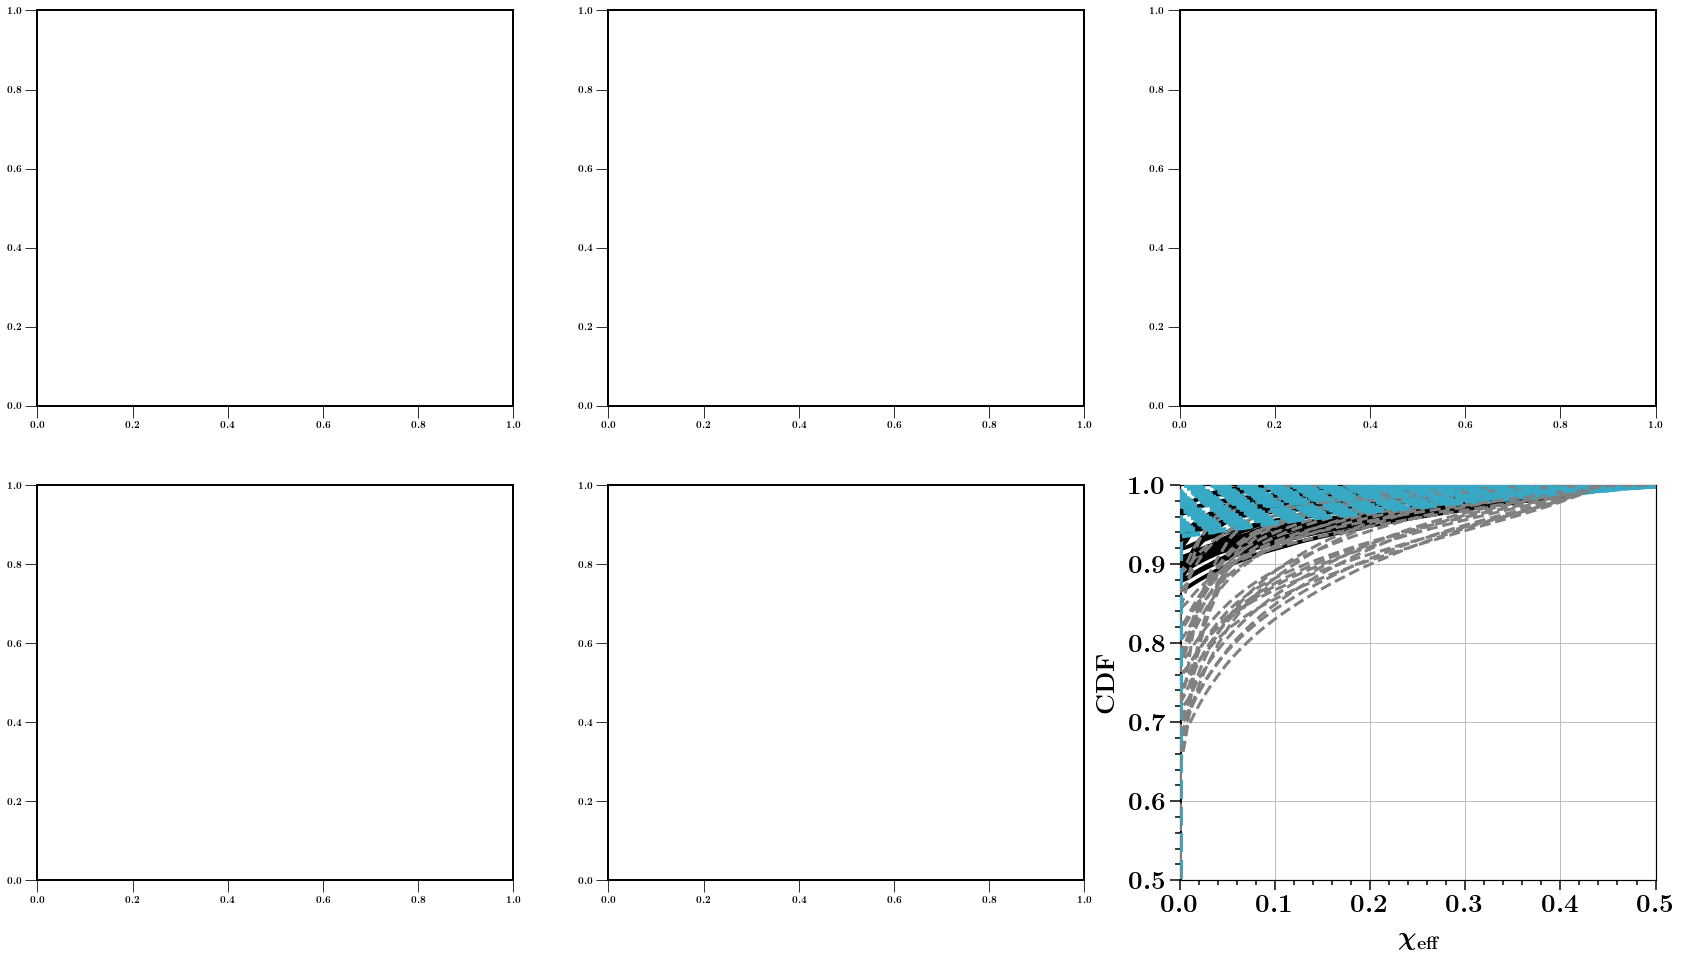

In [8]:

for BPS in [BPSnameslist[14]]:
    
    f, axx= plt.subplots(ncols=3,nrows=2,figsize=(29,16))
    # plot M1ZAMS on the left panel
#     xvar, label, xmin, xmax ='M1LVK',  r'$M_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', 1, 43    
#     plotHist_OtherModels(axe=axx[0,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

#     xvar, label, xmin, xmax ='M2LVK', r'$M_{\rm{BH,2}} \ [\rm{M}_{\odot}]$', 1, 43    
#     plotHist_OtherModels(axe=axx[0,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

#     xvar, label, xmin, xmax ='qLVK', r'$\textbf{BBH} \ \textbf{mass} \ \textbf{ratio} \ q  $', 0, 1    
#     plotHist_OtherModels(axe=axx[0,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
#     print('at second rw')
#     #### second row #####
#     xvar, label, xmin, xmax ='Chirp_mass',  r'$M_{\rm{c}} \ [\rm{M}_{\odot}]$', 1, 37    
#     plotHist_OtherModels(axe=axx[1,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

#     xvar, label, xmin, xmax ='Total_mass', r'$M_{\rm{tot}} \ [\rm{M}_{\odot}]$', 1, 84    
#     plotHist_OtherModels(axe=axx[1,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='Effective_spin', r'$\chi_{\rm{eff}}$', 0., 1    
    plotHist_OtherModels(axe=axx[1,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
        
    print('almost done... saving figure')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)#2)

    plt.savefig('./CDFsFinalMasses/tempWrong2M_CDF_models_' + 'DoubleMultiPanel' + '_' + BPS + '.eps', format='eps', bbox_inches="tight", dpi=600)
#     plt.savefig('./CDFsFinalMasses/CDF_models_' + 'DoubleMultiPanel' + '_' + BPS + '.eps', format='eps', bbox_inches="tight", dpi=1200)
#     plt.savefig('./CDFsFinalMasses/CDF_models_' + 'DoubleMultiPanel' + '_' + BPS + '.svg', format='svg', bbox_inches="tight", dpi=1200)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()

    plt.close(f)

In [4]:
A = np.asarray([8, 2, 5, 1,2,3,4,1,2,7,8])

In [5]:
u_seedsSN, indices = np.unique(A, return_index=True)

In [6]:
print(u_seedsSN)
print(indices)

print(A[indices])

B = A[np.sort(np.unique(A, return_index=True)[1])]
print(B)
print(np.sort(np.unique(A, return_index=True)[1]))
mask = np.sort(np.unique(A, return_index=True)[1])
print(A[mask])

[1 2 3 4 5 7 8]
[3 1 5 6 2 9 0]
[1 2 3 4 5 7 8]
[8 2 5 1 3 4 7]
[0 1 2 3 5 6 9]
[8 2 5 1 3 4 7]


In [7]:
['MassCOCoreSN',
 'MassCoreSN',
 'MassStarCompanion', 
 'MassStarSN', 
 'Survived',
 'eccentricityBefore', 
 'experiencedRLOF', 
 'fallback', 
 'previousStellarTypeCompanion',
 'previousStellarTypeSN',
 'randomSeed', 
 'separationBefore', 
 'whichStar']


indices = np.sort(np.unique(self.seedsSN[1::2], return_index=True)[1])


['MassCOCoreSN',
 'MassCoreSN',
 'MassStarCompanion',
 'MassStarSN',
 'Survived',
 'eccentricityBefore',
 'experiencedRLOF',
 'fallback',
 'previousStellarTypeCompanion',
 'previousStellarTypeSN',
 'randomSeed',
 'separationBefore',
 'whichStar']